# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning') # Google Drive
    data_folder = Path('/content') # Keep data on Colab

    !pip install pytorch-lightning -U -qq
    !pip install torchinfo -U -qq



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 53.1 MB/s eta 0:00:00


In [3]:
base_folder

PosixPath('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning')

In [4]:
# Change the custom_function_folder to folder in your Google drive folder
# Make sure you keep the mlp_skip_two_layer.py and shared_utils.py files

custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Custom_files') # Your Google Drive

sys.path.append(str(custom_function_folder))
model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Models') # Google drive folder where you want to save model and logs
model_folder.mkdir(parents=True, exist_ok=True)

# <Font color = 'indianred'>**Import Libraries**

In [5]:
# this should not be Google Drive Folder but local folder on Colab
data_folder

PosixPath('/content')

In [6]:
import random
import numpy as np
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import transforms, datasets

# import pytorch_lightning as pl
# from pytorch_lightning.loggers import CSVLogger
# import torchmetrics
# from fastdownload import FastDownload

from fastai.vision.all import *
from torch.utils.data import Dataset, Subset
from fastai.vision.all import PILImage
import torch
from sklearn.model_selection import StratifiedShuffleSplit

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from torchvision.datasets import ImageFolder
import torchmetrics
from fastdownload import FastDownload
from fastai.vision.all import get_image_files, PILImage

# The classea and functions we will import from .py files
from mlp_skip_two_layer import PytorchMLPSkip
from shared_utils import check_loader, check_transforms, check_label_dist, show_confusion_matrix, compute_accuracy, plot_losses_acc

# <Font color = 'indianred'>**Imagenette Dataset**

For this HW, you will use the Imagenette dataset created by fastai https://github.com/fastai/imagenette).

Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

The dataset can be downloaded from this link: https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

Dictionary to map the 10 classes with intergers
```
label_dict = {
    'n01440764' : 0,
    'n02102040' : 1,
    'n02979186' : 2,
    'n03000684' : 3,
    'n03028079' : 4,
    'n03394916' : 5,
    'n03417042' : 6,
    'n03425413' : 7,
    'n03445777' : 8,
    'n03888257' : 9
}

# Array to map integral indices with the actual class names
actual_label_dict = [
    'tench',
    'English springer',
    'cassette player',
    'chain saw',
    'church',
    'French horn',
    'garbage truck',
    'gas pump',
    'golf ball',
    'parachute'
]
```

# <Font color = 'indianred'>**Data Module**
Ceate a LightningDataModule for Imagenette2 Dataset
- Use the images in ```train``` folder to create ``training`` dataset
- Use the images in ``val`` folder to create both ```validation``` and ``test`` datasets.
- <Font color = 'indianred'>**Use 50% of the images in the ```val``` folder for validation dataset and 50% for test dataset.**</font>
- <Font color = 'indianred'>**Use a batch size of 64.**</font>
- The functions(methods) in the class below are mandatory. Add any other methods (functions) as to the class if required.
- Add the functionality to select a stratified random subset of validation and training sets for initial training (Hint see: modified data_loaders_dog_breed.py file on eLearning, please download the file again.)



In [27]:
def get_stratified_subset(data, num_samples_small=1000, labels=None, seed=42):
    if labels is not None:
        _, subset_indices = train_test_split(
            range(len(labels)),  # Just indices, not the actual data
            test_size=num_samples_small,
            stratify=labels,
            random_state=seed
        )
    else:
        _, subset_indices = train_test_split(
            range(len(data)),  # Just indices, not the actual data
            test_size=num_samples_small,
            random_state=seed
        )
    return Subset(data, subset_indices)

In [8]:
def split_dataset(base_dataset, fraction = 0.5, seed=42):
    split_a_size = int(fraction * len(base_dataset))
    split_b_size = len(base_dataset) - split_a_size
    return torch.utils.data.random_split(
        base_dataset,
        [split_a_size, split_b_size],
        generator=torch.Generator().manual_seed(seed)
    )

In [15]:
class ImagenetteDataModule(pl.LightningDataModule):
    def __init__(self,batch_size, url, base_folder, num_samples, img_folder='/content', transform=None, has_labels=False, small_subset = False, seed=42):
        super().__init__()
        self.url = url
        self.img_folder = img_folder  # Convert to Path object for filesystem safety
        self.transform = transform  # Store the transform function
        self.has_labels = has_labels
        self.base_folder = base_folder
        self.batch_size = batch_size
        self.image_files = img_folder
        self.small_subset = small_subset
        self.num_samples = num_samples
        self.seed = seed
        self.n_workers = os.cpu_count() - 1

    def prepare_data(self):
      d = FastDownload(base=self.img_folder, archive='archive', data='datasets')
      folder = d.get(self.url)
      self.image_files = get_image_files('datasets/imagenette2/')

    def setup(self, stage: str):
        self.train = ImageFolder('datasets/imagenette2/train', transform=data_transforms['train'])
        self.val = ImageFolder('datasets/imagenette2/val', transform=data_transforms['test'])
        self.val, self.test = split_dataset(self.val, fraction = 0.5)
        if  self.small_subset:
            self.train_labels = self.train.targets
            self.traintransformed = get_stratified_subset(dataset = self.train, num_samples_small = self.num_samples,\
                                                          labels = self.train_labels)
            self.valid_labels = self.valid.targets
            self.validtransformed = get_stratified_subset(dataset = self.val, num_samples_small = self.num_samples, \
                                                         labels = self.valid_labels)
            self.testtransformed = get_stratified_subset(dataset = self.test, num_samples_small = self.num_samples)

    def train_dataloader(self):
        if self.small_subset:
            return DataLoader(self.traintransformed, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=self.n_workers )
        else:
            return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=self.n_workers)

    def val_dataloader(self):
        if self.small_subset:
            return DataLoader(self.validtransformed, batch_size = self.batch_size, num_workers = self.n_workers)
        else:
            return DataLoader(self.val, batch_size = self.batch_size, num_workers = self.n_workers)

    def test_dataloader(self):
        if self.small_subset:
            return DataLoader(self.testtransformed, batch_size=self.batch_size,num_workers=self.n_workers)
        else:
            return DataLoader(self.test, batch_size = self.batch_size, num_workers = self.n_workers)


# <Font color = 'indianred'>**Data Transforms**

In [16]:
# DO NOT CHANGE THIS CELL
# YOU HAVE TO USE THESE TRANSFORMATIONS
# USE data_transforms['TRAIN] FOR TRAINING SET AND data_transforms['test] FOR BOTH VALIDATION AND TEST SET
data_transforms = {
    "train": transforms.Compose(
        [
            # Resize the shorter side of the image to (500, 375) pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [
            # Resize the shorter side of the image to 640 pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

# <Font color = 'indianred'>**Instantiate Data Module**
- <Font color = 'indianred'>**Use 50% of the images in the ```val``` folder for validation dataset and 50% for test dataset.**</font>
-  <Font color = 'indianred'>**Use a samll subset (1000 samples) for both validation and training dataset** </font>
- <Font color = 'indianred'>**Use a batch size of 64.**</font>


In [17]:
torch.manual_seed(123)
# Use batch size of 64
# Select only 1000
dm = ImagenetteDataModule(batch_size=64, url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz', base_folder = base_folder, small_subset = True, num_samples=1000)

In [18]:
dm.prepare_data()

In [19]:
dm.setup(stage='fit')
check_loader(dm.train_dataloader())

 Batch Number: 1 | Batch size: 64 | x shape: torch.Size([64, 3, 500, 375]) | y shape: torch.Size([64])
 Batch Number: 2 | Batch size: 64 | x shape: torch.Size([64, 3, 500, 375]) | y shape: torch.Size([64])
 Batch Number: 3 | Batch size: 64 | x shape: torch.Size([64, 3, 500, 375]) | y shape: torch.Size([64])

Labels from current batch 
 tensor([6, 0, 4, 2, 4, 9, 1, 9, 2, 6, 1, 1, 8, 0, 7, 3, 8, 9, 1, 9, 3, 9, 3, 2,
        5, 6, 1, 1, 7, 1, 5, 4, 2, 1, 7, 9, 9, 0, 6, 9, 8, 4, 9, 1, 4, 3, 4, 7,
        1, 7, 0, 9, 4, 3, 6, 9, 1, 8, 8, 2, 5, 6, 3, 1])


In [20]:
len(dm.train_dataloader())

15

# <font color = 'indianred'>**LightningModule**

- <font color = 'indianred'>**Use SGD optimizer.** </font>
- <font color = 'indianred'>**Print accuracy and loss at the end of every epoch.**</font>
- <font color = 'indianred'>  **Log loss and accuracy at the end of each epoch or both training and validation.**</font>
- <font color = 'indianred'> **Also log training loss at every 10 steps.**</font>


In [21]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
      inputs, labels = batch
      output = self(inputs)
      loss = F.cross_entropy(output, labels)
      predicted_labels = torch.argmax(output, dim=1)
      return loss, labels, predicted_labels


    def training_step(self, batch, batch_idx):
      loss, labels, predicted_labels = self._shared_step(batch)

      if batch_idx % 10 == 0:
            self.log("train_loss_step", loss, on_step=True, on_epoch=False)

      self.train_acc(predicted_labels, labels)

        # Log for the epoch average
      self.log("train_loss_epoch", loss, on_step=False, on_epoch=True)
      self.log("train_acc", self.train_acc, prog_bar=True, on_step=False, on_epoch=True)

      return loss


    def validation_step(self, batch, batch_idx):
      loss, labels, predicted_labels = self._shared_step(batch)
      self.log("val_loss", loss, on_epoch=True, on_step=False)
      self.val_acc(predicted_labels, labels)
      self.log("val_acc", self.val_acc, prog_bar=True, on_epoch=True, on_step=False)


    def on_train_epoch_end(self):
      metrics = self.trainer.callback_metrics

        # Using 'train_loss_epoch' to get the average loss for the epoch
      print(f"Train_Loss: {metrics['train_loss_epoch']:.2f}, Train_Acc: {metrics['train_acc']:.2f}")



    def on_validation_epoch_end(self):
      metrics = self.trainer.callback_metrics
      epoch_num = self.current_epoch
      print(f"Epoch {epoch_num + 1}: Val_Loss: {metrics['val_loss']:.2f}, Val_Acc: {metrics['val_acc']:.2f}" ,end=" | ", flush=True)



    def configure_optimizers(self):
      optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
      return optimizer


    def test_step(self, batch, batch_idx):
      loss, labels, predicted_labels = self._shared_step(batch)
      self.test_acc(predicted_labels, labels)
      self.log("test_acc", self.test_acc)

In [22]:
# DO NOT CHANGE THIS CELL
# Define the model architecture and training parameters
num_features = 3*500*375
hidden_dim1 = 300
hidden_dim2 = 200
hidden_dim3 = 100
num_classes = 10
epochs = 10
learning_rate = 0.03


# Set a random seed for reproducibility
torch.manual_seed(42)

# Create the neural network model
model = PytorchMLPSkip(num_features, hidden_dim1, hidden_dim2, hidden_dim3, num_classes)

lightning_model = LightningModel(model=model, learning_rate=learning_rate)


# Determine the computing device (CPU or GPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

summary(model, (1, 3, 500, 375))

Layer (type:depth-idx)                   Output Shape              Param #
PytorchMLPSkip                           [1, 10]                   --
├─Flatten: 1-1                           [1, 562500]               --
├─Linear: 1-2                            [1, 300]                  168,750,300
├─ReLU: 1-3                              [1, 300]                  --
├─Linear: 1-4                            [1, 200]                  60,200
├─ReLU: 1-5                              [1, 200]                  --
├─Linear: 1-6                            [1, 100]                  50,100
├─ReLU: 1-7                              [1, 100]                  --
├─Linear: 1-8                            [1, 10]                   3,010
Total params: 168,863,610
Trainable params: 168,863,610
Non-trainable params: 0
Total mult-adds (M): 168.86
Input size (MB): 2.25
Forward/backward pass size (MB): 0.00
Params size (MB): 675.45
Estimated Total Size (MB): 677.71

In [23]:
# DO NOT CHANGE THIS CELL
trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices="auto",  # Uses all available GPUs if applicable
        deterministic=True,
        log_every_n_steps = 10,
        logger=CSVLogger(save_dir=model_folder/'logs', name="skip_two_layer")
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
# DO NOT CHANGE THIS CELL
trainer.fit(
        model=lightning_model,
        datamodule=dm,
    )

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PytorchMLPSkip     | 168 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
168 M     Trainable params
0         Non-trainable params
168 M     Total params
675.454   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Acc: 0.11 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.53, Val_Acc: 0.22 | Train_Loss: 2.32, Train_Acc: 0.21


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 2.19, Val_Acc: 0.27 | Train_Loss: 1.90, Train_Acc: 0.37


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.01, Val_Acc: 0.30 | Train_Loss: 1.55, Train_Acc: 0.50


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 2.02, Val_Acc: 0.33 | Train_Loss: 1.32, Train_Acc: 0.58


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 2.46, Val_Acc: 0.28 | Train_Loss: 1.13, Train_Acc: 0.65


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 2.84, Val_Acc: 0.28 | Train_Loss: 0.85, Train_Acc: 0.77


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 2.23, Val_Acc: 0.32 | Train_Loss: 0.94, Train_Acc: 0.75


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 2.30, Val_Acc: 0.35 | Train_Loss: 0.55, Train_Acc: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 2.45, Val_Acc: 0.33 | Train_Loss: 0.38, Train_Acc: 0.91


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 2.57, Val_Acc: 0.33 | Train_Loss: 0.27, Train_Acc: 0.93


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## <Font color = 'indianred'>**Plot Losses**

In [25]:
# DO NOT CHANGE THIS CELL
file = f"{trainer.logger.log_dir}/metrics.csv"
file


'/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Models/logs/skip_two_layer/version_1/metrics.csv'

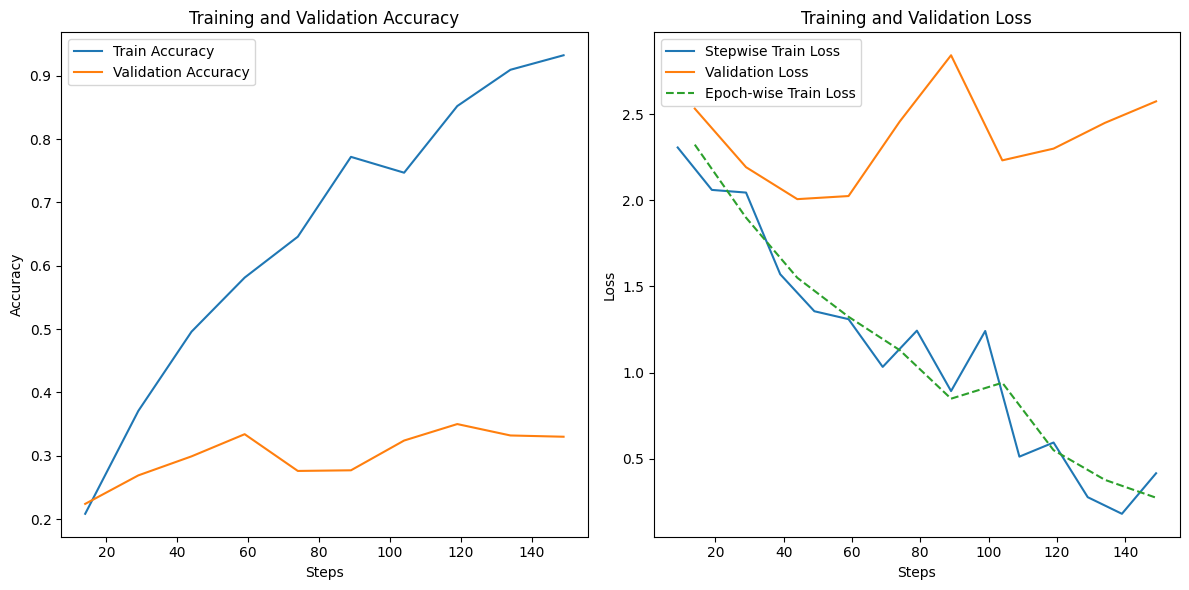

In [26]:
# DO NOT CHANGE THIS CELL
plot_losses_acc(file)